In [112]:
# Ячейка 1: Импорты
# !pip install torchvision
# !pip install annoy
# !pip install tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms
from pathlib import Path
import numpy as np
from annoy import AnnoyIndex
import pickle
import os
from PIL import Image
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

In [113]:
# Ячейка 2: Определение ImageEncoder с ConvNeXT
class ImageEncoder:
    def __init__(self):
        print("Loading ConvNeXT model...")
        self.model = models.convnext_large(pretrained=True)
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        self.model.eval()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        
        self.transform = transforms.Compose([
            transforms.Resize(236, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        print(f"Model loaded successfully on {self.device}!")

    def get_embedding(self, image_path):
        try:
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image).unsqueeze(0)
            image = image.to(self.device)
            
            with torch.no_grad():
                embedding = self.model(image)
                
            embedding = embedding.squeeze().cpu().numpy()
            embedding = embedding / np.linalg.norm(embedding)
            return embedding
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            return None

In [114]:
# Ячейка 3: Создание экземпляра энкодера
encoder = ImageEncoder()

Loading ConvNeXT model...


/home/moo/PycharmProjects/jupyter-venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/moo/PycharmProjects/jupyter-venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully on cuda!


In [115]:
# Ячейка 4: Функции для обработки датасета
def process_dataset(dataset_path, encoder, save_dir="./data_s1"):
    dataset_path = Path(dataset_path)
    
    embeddings_dict = {}
    file_mapping = {}
    class_mapping = {}
    reverse_class_mapping = {}  # для быстрого получения класса по имени файла
    class_stats = defaultdict(int)
    
    idx = 0
    print("Processing dataset...")
    
    for class_dir in tqdm(list(dataset_path.iterdir())):
        if class_dir.is_dir():
            class_name = class_dir.name
            for image_file in class_dir.glob("*.*"):
                if image_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    embedding = encoder.get_embedding(str(image_file))
                    if embedding is not None:
                        embeddings_dict[idx] = embedding
                        file_mapping[idx] = image_file.name
                        class_mapping[idx] = class_name
                        reverse_class_mapping[image_file.name] = class_name
                        class_stats[class_name] += 1
                        idx += 1
    
    print(f"\nTotal images processed: {idx}")
    print("\nClass distribution:")
    for class_name, count in class_stats.items():
        print(f"{class_name}: {count} images")
    
    os.makedirs(save_dir, exist_ok=True)
    with open(f"{save_dir}/processed_data.pkl", "wb") as f:
        pickle.dump({
            'embeddings': embeddings_dict,
            'file_mapping': file_mapping,
            'class_mapping': class_mapping,
            'reverse_class_mapping': reverse_class_mapping,
            'class_stats': dict(class_stats)
        }, f)
    
    return embeddings_dict, file_mapping, class_mapping, reverse_class_mapping

In [116]:
# Ячейка 5: Обработка тренировочного датасета
dataset_path = "/home/moo/Downloads/train_dataset_train_data_rkn/train_data_rkn/train"  # Укажите путь к тренировочному датасету
embeddings_dict, file_mapping, class_mapping, reverse_class_mapping = process_dataset(dataset_path, encoder)

Processing dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [04:47<00:00,  2.74s/it]


Total images processed: 15427

Class distribution:
Microwave oven: 296 images
Hat: 160 images
Elephant: 4 images
Wine rack: 112 images
Tap: 160 images
Snowboard: 156 images
Jacket: 160 images
Wok: 160 images
Aircraft: 160 images
Lighthouse: 160 images
Piano: 156 images
Cat: 162 images
Binoculars: 85 images
Koala: 160 images
Woodpecker: 145 images
Magpie: 98 images
Vase: 160 images
Plastic bag: 160 images
Accordion: 160 images
Bottle: 156 images
Jet ski: 160 images
Cello: 5 images
Ipod: 160 images
Tablet computer: 160 images
Rocket: 160 images
Bread: 160 images
Harp: 160 images
Bathtub: 160 images
Helmet: 159 images
Submarine: 60 images
Seahorse: 160 images
Honeycomb: 160 images
Cannon: 160 images
Cosmetics: 160 images
Adhesive tape: 87 images
Apple: 162 images
Laptop: 160 images
Sparrow: 295 images
Spoon: 160 images
Wood-burning stove: 155 images
Flashlight: 49 images
Lily: 300 images
Monkey: 160 images
Isopod: 69 images
Sombrero: 160 images
Goldfish: 217 images
Cassette deck: 42 imag

In [117]:
# Ячейка 6: Создание и сохранение индекса
def build_index(embeddings_dict, save_dir="./data_s1"):
    first_embedding = next(iter(embeddings_dict.values()))
    embedding_dim = len(first_embedding)
    
    index = AnnoyIndex(embedding_dim, 'angular')
    
    print("Building index...")
    for idx, embedding in embeddings_dict.items():
        index.add_item(idx, embedding)
    
    print("Building index with 100 trees...")
    index.build(100)
    index.save(f"{save_dir}/image_index.ann")
    
    return index

index = build_index(embeddings_dict)

Building index...
Building index with 100 trees...


In [118]:
# Ячейка 7: Функция поиска похожих изображений
def find_similar(query_image_path, index, encoder, file_mapping, class_mapping, n_results=10):
    query_embedding = encoder.get_embedding(query_image_path)
    if query_embedding is None:
        return []
    
    n_candidates = min(n_results * 3, len(file_mapping))
    similar_idx, distances = index.get_nns_by_vector(
        query_embedding, n_candidates, include_distances=True)
    
    filtered_results = []
    seen_classes = set()
    
    for idx, dist in zip(similar_idx, distances):
        class_name = class_mapping[idx]
        if len(filtered_results) < n_results:
            if class_name not in seen_classes:
                filtered_results.append(file_mapping[idx])
                seen_classes.add(class_name)
    
    while len(filtered_results) < n_results and similar_idx:
        idx = similar_idx[len(filtered_results)]
        filtered_results.append(file_mapping[idx])
    
    return filtered_results

### Отдельно

In [76]:
from pathlib import Path
import numpy as np
from collections import defaultdict
import csv

In [ ]:


# def evaluate_recommendations(test_dir, index, encoder, file_mapping, class_mapping, dataset_path,
#                              test_class_mapping_file, output_file="submission_s1.csv"):
#     """
#     Генерация рекомендаций и подсчет метрик
#     """
#     test_path = Path(test_dir)
#     results = []
#     predictions = {}

#     print("Generating recommendations for test images...")
#     for image_file in tqdm(list(test_path.glob("*.*"))):
#         if image_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
#             similar_images = find_similar(
#                 str(image_file), index, encoder, file_mapping,
#                 class_mapping, n_results=10
#             )

#             if similar_images:
#                 recs = ",".join(similar_images)
#                 results.append({
#                     'image': image_file.name,  # Используем image_file.name
#                     'recs': f'"{recs}"'
#                 })
#                 predictions[image_file.name] = similar_images  # Используем image_file.name

#     # Сохраняем результаты
#     df = pd.DataFrame(results)
#     df.to_csv(output_file, index=False)
#     print(f"\nSubmission saved to {output_file}")

#     # Считаем метрики
#     map10, class_map = calculate_map10(predictions, dataset_path, test_class_mapping_file)

#     print(f"\nOverall MAP@10: {map10:.4f}")
#     print("\nMAP@10 by class:")
#     # for class_name, class_score in sorted(class_map.items(), key=lambda x: x[1], reverse=True):
#     #     print(f"{class_name}: {class_score:.4f}")

#     return predictions, map10, class_map

In [121]:
def calculate_map10(predictions, dataset_path, test_class_mapping_file):
    """
    Правильный расчет MAP@10 на основе классов изображений

    Args:
        predictions: dict {query_image: [recommended_images]}
        dataset_path: путь к тренировочному датасету
        test_class_mapping_file: путь к CSV-файлу с маппингом тестовых изображений к классам
    """
    dataset_path = Path(dataset_path)
    ap_scores = []
    class_performances = defaultdict(list)

    # Создаем маппинг классов для тренировочных изображений
    train_class_mapping = {}
    for class_dir in dataset_path.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            for img_path in class_dir.glob("*.*"):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    train_class_mapping[img_path.name] = class_name  # Используем img_path.name для включения расширения

    # Загружаем маппинг классов для тестовых изображений из CSV-файла
    test_class_mapping = {}
    with open(test_class_mapping_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            test_class_mapping[row['image_name']] = row['class_name']

    # Проверка наличия изображений в маппингах
    # if not train_class_mapping:
        # print("Ошибка: train_class_mapping пуст.")
    # if not test_class_mapping:
        # print("Ошибка: test_class_mapping пуст.")

    # Для каждого тестового изображения
    for query_image, recommended_images in predictions.items():
        # Находим класс тестового изображения
        query_class = test_class_mapping.get(query_image)
        if query_class is None:
            # print(f"Класс не найден для тестового изображения: {query_image}")
            continue

        # Считаем релевантность для каждой позиции
        relevance = []
        for rec_image in recommended_images[:10]:
            rec_class = train_class_mapping.get(rec_image)
            if rec_class is None:
                # print(f"Класс не найден для рекомендованного изображения: {rec_image}")
                is_relevant = 0
            else:
                is_relevant = 1 if rec_class == query_class else 0
            relevance.append(is_relevant)

        # Считаем AP@10
        precision_at_k = []
        num_relevant = 0

        for k, is_relevant in enumerate(relevance, 1):
            if is_relevant:
                num_relevant += 1
                precision_at_k.append(num_relevant / k)

        if num_relevant > 0:
            ap = sum(precision_at_k) / num_relevant
            ap_scores.append(ap)
            class_performances[query_class].append(ap)
        else:
            # Если нет релевантных результатов, добавляем AP=0
            ap_scores.append(0)
            class_performances[query_class].append(0)

    # Считаем общий MAP@10
    map10 = np.mean(ap_scores) if ap_scores else 0

    # Считаем MAP@10 по классам
    class_map = {cls: np.mean(scores) for cls, scores in class_performances.items()}

    return map10, class_map


def evaluate_recommendations(test_dir, index, encoder, file_mapping, class_mapping, dataset_path, test_class_mapping_file,
                             output_file="submission_s1.csv"):
    """
    Генерация рекомендаций и подсчет метрик с дополнительной логикой улучшения.
    """
    from pathlib import Path
    import pandas as pd
    from tqdm import tqdm

    test_path = Path(test_dir)
    results = []
    predictions = {}

    print("Generating recommendations for test images...")
    for image_file in tqdm(list(test_path.rglob("*.*"))):
        if image_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            query_image_path = str(image_file)
            query_embedding = encoder.get_embedding(query_image_path)
            if query_embedding is None:
                continue

            # Получаем больше кандидатов для анализа
            n_candidates = 30  # Можно настроить это значение
            similar_idx, distances = index.get_nns_by_vector(
                query_embedding, n_candidates, include_distances=True)

            # Получаем информацию о классах и файлах
            candidate_classes = []
            candidate_files = []
            for idx in similar_idx:
                candidate_classes.append(class_mapping[idx])
                candidate_files.append(file_mapping[idx])

            # Проверка первого условия: очень похожее изображение
            # Можно установить порог для расстояния
            similarity_threshold = 0.75  # Настройте это значение в зависимости от ваших данных
            if distances[0] < similarity_threshold:
                assigned_class = candidate_classes[0]
                # Берем топ-10 изображений из этого класса
                class_images = [file_mapping[idx] for idx, cls in zip(similar_idx, candidate_classes) if cls == assigned_class]
                similar_images = class_images[:10]
            else:
                # Проверка второго условия: большинство изображений из одного класса
                class_counts = {}
                for cls in candidate_classes[:10]:
                    class_counts[cls] = class_counts.get(cls, 0) + 1

                # Находим класс с наибольшим числом появлений
                most_common_class = max(class_counts, key=class_counts.get)
                if class_counts[most_common_class] >= 6:
                    assigned_class = most_common_class
                    # Берем топ-10 изображений из этого класса
                    class_images = [file_mapping[idx] for idx, cls in zip(similar_idx, candidate_classes) if cls == assigned_class]
                    similar_images = class_images[:10]
                else:
                    # Если ни одно из условий не выполнено, берем первоначальные рекомендации
                    similar_images = candidate_files[:10]

            # Сохраняем результаты
            if similar_images:
                recs = ",".join(similar_images)
                results.append({
                    'image': image_file.name,  # Используем image_file.name
                    'recs': f'"{recs}"'
                })
                predictions[image_file.name] = similar_images  # Используем image_file.name

    # Сохраняем результаты
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)
    print(f"\nSubmission saved to {output_file}")

    # Считаем метрики
    map10, class_map = calculate_map10(predictions, dataset_path, test_class_mapping_file)

    print(f"\nOverall MAP@10: {map10:.4f}")
    print("\nMAP@10 by class:")
    for class_name, class_score in sorted(class_map.items(), key=lambda x: x[1], reverse=True):
        print(f"{class_name}: {class_score:.4f}")

    return predictions, map10, class_map



def analyze_failure_cases(predictions, dataset_path, test_path, class_map):
    """
    Анализ проблемных случаев
    """
    worst_classes = sorted(class_map.items(), key=lambda x: x[1])[:5]
    print("\nAnalyzing worst performing classes:")
    
    dataset_path = Path(dataset_path)
    test_path = Path(test_path)
    
    # Создаем маппинг классов
    train_class_mapping = {}
    for class_dir in dataset_path.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            for img_path in class_dir.glob("*.*"):
                train_class_mapping[img_path.stem] = class_name
    
    for class_name, score in worst_classes:
        print(f"\nClass: {class_name}, MAP@10: {score:.4f}")
        
        # Находим примеры ошибок для этого класса
        for query_image, recs in predictions.items():
            query_class = None
            for class_dir in test_path.iterdir():
                if class_dir.is_dir() and any(f.stem == query_image for f in class_dir.glob("*.*")):
                    query_class = class_dir.name
                    break
            
            if query_class == class_name:
                print(f"\nQuery image: {query_image}")
                print("Top 5 recommendations and their classes:")
                for i, rec in enumerate(recs[:5], 1):
                    rec_class = train_class_mapping.get(rec, "unknown")
                    print(f"{i}. {rec} (class: {rec_class})")


Generating recommendations for test images...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3899/3899 [01:16<00:00, 50.94it/s]



Submission saved to submission_s1.csv

Overall MAP@10: 0.7455

MAP@10 by class:
Ambulance: 1.0000
Ant: 1.0000
Cannon: 1.0000
Hippopotamus: 1.0000
Parking meter: 1.0000
Cassette deck: 1.0000
Submarine: 1.0000
Jet ski: 1.0000
Wrench: 1.0000
Alpaca: 0.9750
Honeycomb: 0.9750
Rocket: 0.9750
Bow and arrow: 0.9750
Snowboard: 0.9750
Koala: 0.9750
Lighthouse: 0.9580
Harp: 0.9525
Ipod: 0.9500
Barge: 0.9250
Sparrow: 0.9214
Magpie: 0.9200
Wood-burning stove: 0.9200
Willow: 0.9164
Monkey: 0.9163
Wine rack: 0.9140
Worm: 0.9125
Rhinoceros: 0.9076
Alarm clock: 0.9038
Bathtub: 0.9030
Goldfish: 0.9022
Zebra: 0.8867
Microwave oven: 0.8861
Whiteboard: 0.8807
Artichoke: 0.8788
Accordion: 0.8750
Isopod: 0.8724
Goat: 0.8694
Lily: 0.8636
Toilet paper: 0.8605
Banana: 0.8500
Common fig: 0.8500
Binoculars: 0.8475
Broccoli: 0.8444
Reptile: 0.8381
Horse: 0.8347
Cat: 0.8296
Limousine: 0.8292
Whisk: 0.8203
Sombrero: 0.8171
Camera: 0.8138
Plastic bag: 0.8107
Piano: 0.8103
Vase: 0.8091
Bread: 0.8048
Rabbit: 0.8036
La

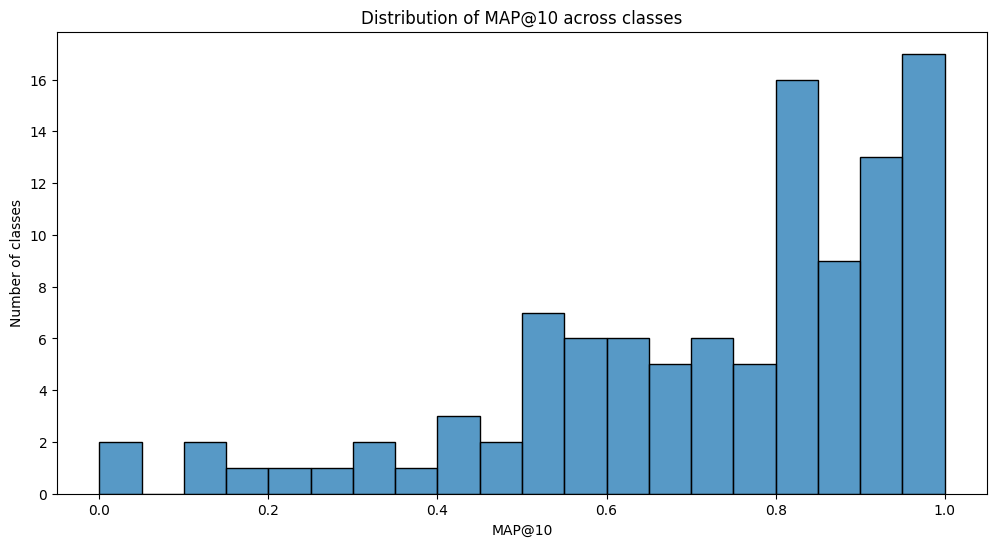

In [122]:
# Использование
test_dir = "/home/moo/Downloads/train_dataset_train_data_rkn/train_data_rkn/valid"
dataset_path = "/home/moo/Downloads/train_dataset_train_data_rkn/train_data_rkn/train"
valid_mapping_file = '/home/moo/Downloads/train_dataset_train_data_rkn/train_data_rkn/valid_mapping.csv'

predictions, map10, class_map = evaluate_recommendations(
    test_dir=test_dir,
    index=index,
    encoder=encoder,
    file_mapping=file_mapping,
    class_mapping=class_mapping,
    dataset_path=dataset_path,
    test_class_mapping_file=valid_mapping_file
)

# Анализ проблемных случаев
# analyze_failure_cases(predictions, dataset_path, test_dir, class_map)

# Визуализация распределения MAP@10 по классам
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(list(class_map.values()), bins=20)
plt.title('Distribution of MAP@10 across classes')
plt.xlabel('MAP@10')
plt.ylabel('Number of classes')
plt.show()

### На всем датасете

In [123]:
def calculate_map10(predictions, dataset_path, test_dataset_path):
    """
    Правильный расчет MAP@10 на основе классов изображений

    Args:
        predictions: dict {query_image: [recommended_images]}
        dataset_path: путь к тренировочному датасету
        test_dataset_path: путь к тестовому датасету (структура папок по классам)
    """
    from pathlib import Path
    import numpy as np
    from collections import defaultdict

    dataset_path = Path(dataset_path)
    test_dataset_path = Path(test_dataset_path)
    ap_scores = []
    class_performances = defaultdict(list)

    # Создаем маппинг классов для тренировочных изображений
    train_class_mapping = {}
    for class_dir in dataset_path.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            for img_path in class_dir.glob("*.*"):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    train_class_mapping[img_path.name] = class_name

    # Создаем маппинг классов для тестовых изображений
    test_class_mapping = {}
    for class_dir in test_dataset_path.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            for img_path in class_dir.glob("*.*"):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    test_class_mapping[img_path.name] = class_name

    for query_image, recommended_images in predictions.items():
        query_class = test_class_mapping.get(query_image)
        if query_class is None:
            print(f"Класс не найден для тестового изeображения: {query_image}")
            continue

        relevance = []
        for rec_image in recommended_images[:10]:
            rec_class = train_class_mapping.get(rec_image)
            if rec_class is None:
                print(f"Класс не найден для рекомендованного изображения: {rec_image}")
                is_relevant = 0
            else:
                is_relevant = 1 if rec_class == query_class else 0
            relevance.append(is_relevant)

        # Считаем AP@10
        precision_at_k = []
        num_relevant = 0

        for k, is_relevant in enumerate(relevance, 1):
            if is_relevant:
                num_relevant += 1
                precision_at_k.append(num_relevant / k)

        if num_relevant > 0:
            ap = sum(precision_at_k) / num_relevant
            ap_scores.append(ap)
            class_performances[query_class].append(ap)
        else:
            # Если нет релевантных результатов, добавляем AP=0
            ap_scores.append(0)
            class_performances[query_class].append(0)

    # Считаем общий MAP@10
    map10 = np.mean(ap_scores) if ap_scores else 0

    # Считаем MAP@10 по классам
    class_map = {cls: np.mean(scores) for cls, scores in class_performances.items()}

    return map10, class_map


In [126]:
def evaluate_recommendations(test_dir, index, encoder, file_mapping, class_mapping, dataset_path,
                             output_file="submission_s1.csv"):
    """
    Генерация рекомендаций и подсчет метрик с использованием кастомной логики.
    """
    from pathlib import Path
    import pandas as pd
    from tqdm import tqdm

    test_path = Path(test_dir)
    results = []
    predictions = {}

    print("Generating recommendations for test images...")
    for image_file in tqdm(list(test_path.rglob("*.*"))):  # Используем rglob("*.*") для рекурсивного поиска
        if image_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            query_image_path = str(image_file)
            query_embedding = encoder.get_embedding(query_image_path)
            if query_embedding is None:
                continue

            # Получаем больше кандидатов для анализа
            n_candidates = 30  # Настройте это значение по необходимости
            similar_idx, distances = index.get_nns_by_vector(
                query_embedding, n_candidates, include_distances=True
            )

            # Получаем информацию о классах и файлах
            candidate_classes = []
            candidate_files = []
            candidate_distances = []
            for idx, dist in zip(similar_idx, distances):
                candidate_file = file_mapping[idx]
                if candidate_file == image_file.name:
                    continue  # Пропускаем само изображение-запрос
                candidate_classes.append(class_mapping[idx])
                candidate_files.append(candidate_file)
                candidate_distances.append(dist)

            # Проверяем, есть ли достаточно кандидатов после исключения запроса
            if len(candidate_files) == 0:
                continue  # Нет кандидатов для этого запроса

            # Обновляем distances без учёта исключённых изображений
            distances = candidate_distances

            # Кастомная логика
            similarity_threshold = 0.85  # Настройте это значение

            if distances[0] < similarity_threshold:
                assigned_class = candidate_classes[0]
                # Берём топ-10 изображений из этого класса
                class_images = [f for f, cls in zip(candidate_files, candidate_classes) if cls == assigned_class]
                similar_images = class_images[:10]
            else:
                # Проверка второго условия: большинство изображений из одного класса
                class_counts = {}
                for cls in candidate_classes[:10]:
                    class_counts[cls] = class_counts.get(cls, 0) + 1

                # Находим класс с наибольшим числом появлений
                most_common_class = max(class_counts, key=class_counts.get)
                if class_counts[most_common_class] >= 6:
                    assigned_class = most_common_class
                    # Берём топ-10 изображений из этого класса
                    class_images = [f for f, cls in zip(candidate_files, candidate_classes) if cls == assigned_class]
                    similar_images = class_images[:10]
                else:
                    # Если ни одно из условий не выполнено, берём первоначальные рекомендации
                    similar_images = candidate_files[:10]

            # Сохраняем результаты
            if similar_images:
                recs = ",".join(similar_images)
                results.append({
                    'image': image_file.name,  # Используем image_file.name
                    'recs': f'"{recs}"'
                })
                predictions[image_file.name] = similar_images  # Используем image_file.name

    # Сохраняем результаты
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)
    print(f"\nSubmission saved to {output_file}")

    # Считаем метрики
    map10, class_map = calculate_map10(predictions, dataset_path, test_dir)

    print(f"\nOverall MAP@10: {map10:.4f}")
    print("\nMAP@10 by class:")
    for class_name, class_score in sorted(class_map.items(), key=lambda x: x[1], reverse=True):
        print(f"{class_name}: {class_score:.4f}")

    return predictions, map10, class_map


In [128]:
def evaluate_recommendations(test_dir, index, encoder, file_mapping, class_mapping, dataset_path,
                             output_file="submission_s1.csv"):
    """
    Генерация рекомендаций и подсчет метрик
    """
    from pathlib import Path
    import pandas as pd
    from tqdm import tqdm

    test_path = Path(test_dir)
    results = []
    predictions = {}

    print("Generating recommendations for test images...")
    for image_file in tqdm(list(test_path.rglob("*.*"))):  # Изменено на rglob("*.*")
        if image_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            similar_images = find_similar(
                str(image_file), index, encoder, file_mapping,
                class_mapping, n_results=10
            )

            if similar_images:
                recs = ",".join(similar_images)
                results.append({
                    'image': image_file.name,  # Используем image_file.name
                    'recs': f'"{recs}"'
                })
                predictions[image_file.name] = similar_images  # Используем image_file.name

    # Сохраняем результаты
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)
    print(f"\nSubmission saved to {output_file}")

    # Считаем метрики
    map10, class_map = calculate_map10(predictions, dataset_path, test_dir)

    print(f"\nOverall MAP@10: {map10:.4f}")
    print("\nMAP@10 by class:")
    for class_name, class_score in sorted(class_map.items(), key=lambda x: x[1], reverse=True):
        print(f"{class_name}: {class_score:.4f}")

    return predictions, map10, class_map

In [129]:
test_dir = "/home/moo/Downloads/train_dataset_train_data_rkn/train_data_rkn/train"  # Ваш тестовый датасет
dataset_path = "/home/moo/Downloads/train_dataset_train_data_rkn/train_data_rkn/train"  # Ваш тренировочный датасет

predictions, map10, class_map = evaluate_recommendations(
    test_dir=test_dir,
    
    index=index,
    encoder=encoder,
    file_mapping=file_mapping,
    class_mapping=class_mapping,
    dataset_path=dataset_path
)


Generating recommendations for test images...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15554/15554 [07:15<00:00, 35.70it/s]



Submission saved to submission_s1.csv

Overall MAP@10: 0.8617

MAP@10 by class:
Elephant: 1.0000
Cello: 1.0000
Honeycomb: 0.9990
Harp: 0.9975
Parking meter: 0.9947
Koala: 0.9946
Bow and arrow: 0.9916
Woman: 0.9905
Hippopotamus: 0.9886
Submarine: 0.9864
Lighthouse: 0.9843
Artichoke: 0.9837
Goldfish: 0.9822
Zebra: 0.9777
Hat: 0.9771
Jet ski: 0.9759
Alpaca: 0.9743
Ambulance: 0.9735
Glasses: 0.9710
Ant: 0.9704
Animal: 0.9693
Snowboard: 0.9600
Accordion: 0.9597
Magpie: 0.9591
Briefcase: 0.9484
Alarm clock: 0.9482
Lion: 0.9461
Ipod: 0.9451
Limousine: 0.9450
Rocket: 0.9445
Cannon: 0.9438
Binoculars: 0.9425
Broccoli: 0.9424
Belt: 0.9360
Adhesive tape: 0.9358
Jacket: 0.9338
Piano: 0.9329
Rabbit: 0.9323
Cassette deck: 0.9270
Land vehicle: 0.9118
Toilet paper: 0.9084
Lily: 0.9037
Banana: 0.8964
Skull: 0.8948
Microwave oven: 0.8935
Sparrow: 0.8925
Coin: 0.8896
Willow: 0.8880
Camera: 0.8855
Common fig: 0.8822
Plastic bag: 0.8793
Whisk: 0.8761
Monkey: 0.8723
Wood-burning stove: 0.8715
Christmas tre